# Simple Neural Network - Binary Classification
###### Neural network from scratch

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nn_utils import plot_decision_boundary, load_2D_dataset
import warnings


# ignore warnings by message (caused by log of zeros/close-to-zero numbers during training):
warnings.filterwarnings('ignore', message='divide by zero encountered in log')
warnings.filterwarnings('ignore', message='invalid value encountered in multiply')

In [19]:
class NN_Model():
    __PRINT_COST_INTERVAL = 2000    # the interval (i.e. iteration #) when the cost should be printed
    __EPSILON = 1e-8                # a small value greater than zero
    
    def __init__(self,
                 X,
                 Y,
                 hidden_layers,
                 learning_rate,
                 num_iterations,
                 regularization=None,
                 lambda_=0.1,
                 initialization=None,
                 optimizer=None,
                 print_cost=False):
        np.random.seed(1)

        self.X = X # inputs
        self.Y = Y # labels

        self.num_iterations = num_iterations
        self.learning_rate = learning_rate
        self.print_cost = print_cost                        # boolean - determines if costs per interval should be printed
        self.regularization = str(regularization).upper()   # type of regularization to be implemented
        self.lambda_ = lambda_                              # lambda constant used for L2 regularization equation

        self.b = {}             # bias unit (trainable); each key represents layer
        self.W = {}             # weights (trainable); each key represents layer
        self.Z = {}             # linear unit; each key represents layer
        self.A = {0: X}         # post-activation unit; each key represents layer; 0th layer is just input layer
        self.db = {}            # gradient of bias unit; each key represents layer
        self.dW = {}            # gradient of weights; each key represents layer
        self.dA = {}            # gradient of post-activation unit; each key represents layer
        self.costs = []         # the cost at a given interval/number of iterations, __PRINT_COST_INTERVAL
        self.m = X.shape[1]     # number of training examples

        self.is_training = True         # boolean to indicate training vs testing/predicting
        self.dropout_mask = {}          # the mask of boolean values (per layer) used for dropout regularization

        # array of layer shapes (nodes per layer), including input and output layers:
        self.layers = [{'size': X.shape[0]}] + hidden_layers + [{'size': 1}]
        self.L = len(self.layers)-1  # number of layers

        # for gradient optimization:
        # TODO: make Adam beta values user tunable; though, tuning them is rare:
        self.beta1_adam = 0.9
        self.beta2_adam = 0.999
        self.beta_momentum = 0.9

        self.optimizer = optimizer.upper()
        if self.optimizer == 'MOMENTUM' or self.optimizer == 'ADAM':
            self.moving_avg_dW = {}  # aka exponentially weighted average of dW -- its "velocity" (v)
            self.moving_avg_db = {}  # aka exponentially weighted average of db -- its "velocity" (v)
        if self.optimizer == 'ADAM':
            self.moving_avg_squares_dW = {}  # aka exponentially weighted average of squares of dW
            self.moving_avg_squares_db = {}  # aka exponentially weighted average of squares of db

        # initialize parameters, W and b:
        for l in range(1, self.L+1):
            # ensure hidden_layers was properly passed as a list of dictionaries:
            # TODO: n.b. code will fail anyway if hidden layers is not properly defined,
            #  so this is check is mostly for the additional error hint and may not be that useful
            if type(self.layers[l]) != dict and 'size' not in self.layers[l]:
                raise TypeError('each item in "layers" must be a dict and must have a property of "size"')

            # determine layer sizes:
            layer_size = self.layers[l]['size']
            previous_layer_size = self.layers[l-1]['size']

            self.W[l] = np.random.randn(layer_size, previous_layer_size)
            self.b[l] = np.zeros((layer_size, 1))

            # weights initialization (scaling weights):
            initialization = str(initialization).upper()

            if initialization == 'HE':
                self.W[l] *= 2 / np.sqrt(previous_layer_size)
            elif initialization == 'XAVIER':
                self.W[l] *= 1 / np.sqrt(previous_layer_size)
            else:
                self.W[l] *= 0.01

            # initialize velocity (if selected) to zeros:
            W_shape = self.W[l].shape
            b_shape = self.b[l].shape
            if self.optimizer == 'MOMENTUM' or self.optimizer == 'ADAM':
                self.moving_avg_dW[l] = np.zeros(W_shape)
                self.moving_avg_db[l] = np.zeros(b_shape)
            if self.optimizer == 'ADAM':
                self.moving_avg_squares_dW[l] = np.zeros(W_shape)
                self.moving_avg_squares_db[l] = np.zeros(b_shape)

    # ########## model training functions: ##########
    def relu(self, Z):
        return np.maximum(Z, 0)
    
    def leaky_relu(self, Z):
        return np.where(Z > 0, Z, 0.01*Z)

    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))

    def relu_gradient(self, Z):
        return np.where(Z > 0, 1, 0)
    
    def leaky_relu_gradient(self, Z):
        return np.where(Z > 0, 1, 0.01)

    def sigmoid_gradient(self, Z):
        return self.sigmoid(Z) * (1 - self.sigmoid(Z))

    def forward_prop(self):
        for l in range(1, self.L+1):
            Z = np.dot(self.W[l], self.A[l-1]) + self.b[l]
            self.Z[l] = np.copy(Z)

            if l == self.L:
                self.A[l] = self.sigmoid(Z)
            else:
                self.A[l] = self.relu(Z)

            # if dropout is set for layer:
            # need to scale the values of neurons that weren't shut down:
            if self.is_training and (type(self.layers[l]) == dict) and ('keep_prob' in self.layers[l]):
                # create matrix of boolean values (with same shape as A)
                # we set value to `1` if RNG is greater than the probability to keep the neuron (`keep_prob`):
                self.dropout_mask[l] = np.random.random((self.A[l].shape[0], self.A[l].shape[1])) < self.layers[l]['keep_prob']
                self.A[l] *= self.dropout_mask[l] # apply mask
                self.A[l] /= self.layers[l]['keep_prob'] # scale by keep_probability

        Y_hat = self.A[self.L]
        return Y_hat

    def back_prop(self):
        for l in reversed(range(1, self.L+1)):
            if l == self.L:
                dZ = self.A[l] - self.Y
                
                # # alternatively, we can compute dZ for layer L the long way -- replace the previous line with:
                # self.dA[l] = -(np.divide(self.Y, self.A[l]) - np.divide(1-self.Y, 1-self.A[l]))
                # dZ = self.dA[l] * self.sigmoid_gradient(self.Z[l]) 
            else:
                dZ = self.dA[l] * self.relu_gradient(self.Z[l])

            self.db[l] = 1.0/self.m * np.sum(dZ, axis=1, keepdims=True)
            self.dA[l-1] = np.dot(self.W[l].T, dZ)
            self.dW[l] = 1.0/self.m * np.dot(dZ, self.A[l-1].T)

            # if dropout is set for layer,
            # apply dropout mask to the same neurons as in forward prop:
            if self.is_training and (type(self.layers[l-1]) == dict) and ('keep_prob' in self.layers[l-1]):
                self.dA[l-1] *= self.dropout_mask[l-1]
                self.dA[l-1] /= self.layers[l-1]['keep_prob']

            # if L2 regularization is set:
            if self.regularization == 'L2':
                 self.dW[l] += self.lambda_/self.m * self.W[l]

    def update_parameters(self, iteration):
        """ Update parameters step during gradient descent. """
        for l in range(1, self.L+1):
            if self.optimizer == 'MOMENTUM':
                self.moving_avg_dW[l] = (self.beta_momentum * self.moving_avg_dW[l]) + ((1-self.beta_momentum) * self.dW[l])
                self.moving_avg_db[l] = (self.beta_momentum * self.moving_avg_db[l]) + ((1-self.beta_momentum) * self.db[l])

                self.W[l] -= self.learning_rate * self.moving_avg_dW[l]
                self.b[l] -= self.learning_rate * self.moving_avg_db[l]
            elif self.optimizer == 'ADAM':
                self.moving_avg_dW[l] = (self.beta1_adam * self.moving_avg_dW[l]) + ((1-self.beta1_adam) * self.dW[l])
                self.moving_avg_db[l] = (self.beta1_adam * self.moving_avg_db[l]) + ((1-self.beta1_adam) * self.db[l])

                # bias correction for exponentially weight avg (i.e. for it to "warm up"):
                moving_avg_dW_corrected = self.moving_avg_dW[l] / (1-np.power(self.beta1_adam, iteration))
                moving_avg_db_corrected = self.moving_avg_db[l] / (1-np.power(self.beta1_adam, iteration))

                self.moving_avg_squares_dW[l] = (self.beta2_adam * self.moving_avg_squares_dW[l]) + ((1-self.beta2_adam) * np.square(self.dW[l]))
                self.moving_avg_squares_db[l] = (self.beta2_adam * self.moving_avg_squares_db[l]) + ((1-self.beta2_adam) * np.square(self.db[l]))

                # bias correction for exponentially weight avgs of squares:
                moving_avg_squares_dW_corrected = self.moving_avg_squares_dW[l] / (1-np.power(self.beta2_adam, iteration))
                moving_avg_squares_db_corrected = self.moving_avg_squares_db[l] / (1-np.power(self.beta2_adam, iteration))

                # combining moving average of gradients (corrected) and moving average of squared gradients (corrected) gives us Adam:
                # n.b. we add epsilon to prevent division by zero:
                self.W[l] -= self.learning_rate * (moving_avg_dW_corrected / (np.sqrt(moving_avg_squares_dW_corrected) + self.__EPSILON))
                self.b[l] -= self.learning_rate * (moving_avg_db_corrected / (np.sqrt(moving_avg_squares_db_corrected) + self.__EPSILON))
            else:
                self.W[l] -= self.learning_rate * self.dW[l]
                self.b[l] -= self.learning_rate * self.db[l]

    def compute_cost(self, Y_hat):
        """
        Compute cost (assuming binary classification, i.e. sigmoid function in last hidden layer)
        
        N.b. cost function will change if regularization is implemented.
        """
        # cross entropy part of cost function:
        cross_entropy_cost = -1/self.m * np.nansum( (self.Y*np.log(Y_hat)) + ((1-self.Y) * np.log(1-Y_hat)) )
        cross_entropy_cost = np.squeeze(cross_entropy_cost)
        
        if self.regularization == 'L2':
            L2_regularization_cost = 1/self.m * self.lambda_/2 * np.sum([np.sum(np.square(self.W[l])) for l in range(1, self.L+1)])
            cost = cross_entropy_cost + L2_regularization_cost
        else:
            cost = cross_entropy_cost

        return cost

    def train(self):
        """ Trains the model after initialization. """
        self.is_training = True
        self.costs = []

        self.print_hyperparameters()

        for i in range(1, self.num_iterations+1):
            Y_hat = self.forward_prop()
            self.back_prop()

            if i == 1 or i % self.__PRINT_COST_INTERVAL == 0:
                cost = self.compute_cost(Y_hat)
                self.costs.append(cost)
                
                # we only want to print cost during training for debugging purposes:
                if self.print_cost:
                    print('cost at iteration %s: %s' % (i, cost))

            self.update_parameters(i)
    
    # ########## public functions: ##########
    def print_hyperparameters(self):
        print('*** Training model with the following hyperparameters: ***')
        print('learning rate (alpha): ', self.learning_rate)
        print('number of iterations:', self.num_iterations)
        if self.optimizer == 'MOMENTUM':
            print('using gradient descent with momentum')
        elif self.optimizer == 'ADAM':
            print('using Adam optimizer')
        else:
            print('using gradient descent')
        print()  # just to create newline

        # TODO: print other hyper parameters
        # TODO: maybe format output a bit?

    def plot_cost(self):
        """ 
        Plots training costs.
        
        Used for debugging training algorithm and hyperparameters.
        """
        
        plt.plot(self.costs)
        plt.title('Cost per Iteration')
        plt.xlabel('Iteration (x%s)' % self.__PRINT_COST_INTERVAL)
        plt.ylabel('Cost')
        plt.show()
    
    def predict(self, X):
        """ Predict (binary classify). """
        self.is_training = False
        self.A[0] = X
        self.m = X.shape[1]
        
        Y_hat = self.forward_prop()
        
        predictions = np.where(Y_hat > 0.5, 1, 0)
        return predictions
    
    def print_accuracy(self, X, Y):
        """ Prints the accuracy of train/test sets. """
        predictions = self.predict(X)
        
        accuracy = np.mean(np.int8(predictions == Y))
        print('Accuracy: %s%%' % (accuracy * 100))

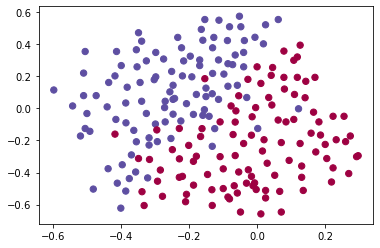

In [3]:
########## main: ##########
train_X, train_Y, test_X, test_Y = load_2D_dataset()

In [28]:
# hyper parameters:
train_hidden_layers = [{'size': 20, 'keep_prob': 0.8}, {'size': 3, 'keep_prob': 0.75}]
train_learning_rate = 0.02
train_num_iterations = 60000

new_model = NN_Model(train_X,
                     train_Y,
                     train_hidden_layers,
                     train_learning_rate,
                     train_num_iterations,
                     initialization='xavier',
                     optimizer='adam',
                     print_cost=True)

In [29]:
new_model.train()

*** Training model with the following hyperparameters: ***
learning rate (alpha):  0.02
number of iterations: 60000
using Adam optimizer

cost at iteration 1: 0.7278445434084359
cost at iteration 2000: 0.23879011105233672
cost at iteration 4000: 0.24126514968864868
cost at iteration 6000: 0.2501013859962965
cost at iteration 8000: 0.25355934638042127
cost at iteration 10000: 0.24812638922997976
cost at iteration 12000: 0.26079928223244575
cost at iteration 14000: 0.18654028658778282
cost at iteration 16000: 0.23938719413155155
cost at iteration 18000: 0.2357391671101984
cost at iteration 20000: 0.23305502928972044
cost at iteration 22000: 0.22757038975464128
cost at iteration 24000: 0.24353068254060892
cost at iteration 26000: 0.2184415118140539
cost at iteration 28000: 0.1973350379701807
cost at iteration 30000: 0.251702026653478
cost at iteration 32000: 0.2337027518446481
cost at iteration 34000: 0.252083431268962
cost at iteration 36000: 0.22512913903207404
cost at iteration 38000: 

/home/deesus/.miniconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: overflow encountered in exp


----- Training set: -----
Accuracy: 93.8388625592417%
----- Test set: -----
Accuracy: 91.5%


/home/deesus/.miniconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: overflow encountered in exp


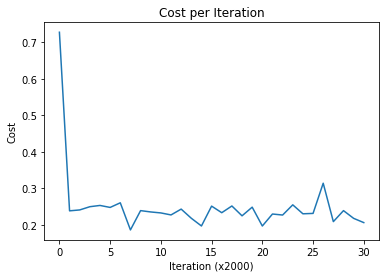

In [31]:
print('----- Training set: -----')
new_model.print_accuracy(train_X, train_Y)
print('----- Test set: -----')
new_model.print_accuracy(test_X, test_Y)

new_model.plot_cost()

/home/deesus/.miniconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: overflow encountered in exp


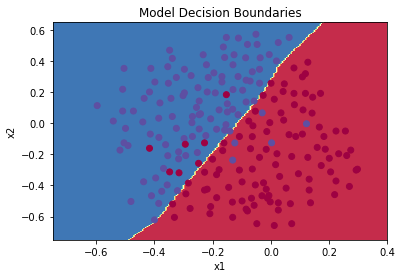

In [32]:
# plot decision boundary after training:
plt.title("Model Decision Boundaries")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: new_model.predict(x.T), train_X, np.squeeze(train_Y))
